## Initialize

In [1]:
import whisper
import pickle
from whisper.tokenizer import get_tokenizer
import numpy as np
import matplotlib.pyplot as plt

from model import load_model
from utils import plot_attention_with_spectrogram


In [2]:
model = load_model('small')
tokenizer = get_tokenizer("small")

## Alignment

In [3]:
input_audio = 'results/quote.wav'

# load audio and pad/trim it to fit 30 seconds
audio_or = whisper.load_audio(input_audio)
audio = whisper.pad_or_trim(audio_or)

# make log-Mel spectrogram and move to the same device as the model
mel_or = whisper.log_mel_spectrogram(audio_or, n_mels=model.dims.n_mels).to(model.device)
mel = whisper.log_mel_spectrogram(audio, n_mels=model.dims.n_mels).to(model.device)

In [4]:
result = model.transcribe(input_audio, verbose=True, word_timestamps=True)
print(result)

Detecting language using up to the first 30 seconds. Use `--language` to specify the language
Detected language: English
[00:00.000 --> 00:02.700]  The best thing in every noble dream is the dreamer.
{'text': ' The best thing in every noble dream is the dreamer.', 'segments': [{'id': 0, 'seek': 0, 'start': 0.0, 'end': 2.7, 'text': ' The best thing in every noble dream is the dreamer.', 'tokens': [50364, 440, 1151, 551, 294, 633, 20171, 3055, 307, 264, 3055, 260, 13, 50514], 'temperature': 0.0, 'avg_logprob': -0.22267627716064453, 'compression_ratio': 0.9807692307692307, 'no_speech_prob': 0.013165559619665146, 'words': [{'word': ' The', 'start': 0.0, 'end': 0.36, 'probability': 0.8662946224212646}, {'word': ' best', 'start': 0.36, 'end': 0.56, 'probability': 0.9926877021789551}, {'word': ' thing', 'start': 0.56, 'end': 0.8, 'probability': 0.9985092282295227}, {'word': ' in', 'start': 0.8, 'end': 0.96, 'probability': 0.9969995021820068}, {'word': ' every', 'start': 0.96, 'end': 1.28, 'pr

In [5]:
with open('results/attention_dict.pkl', 'rb') as f:
    attention_dict = pickle.load(f)

attention_dict.keys()

dict_keys(['all_raw_weights', 'raw_weights', 'alignment_heads', 'token_probs', 'normalized_weights', 'final_matrix'])

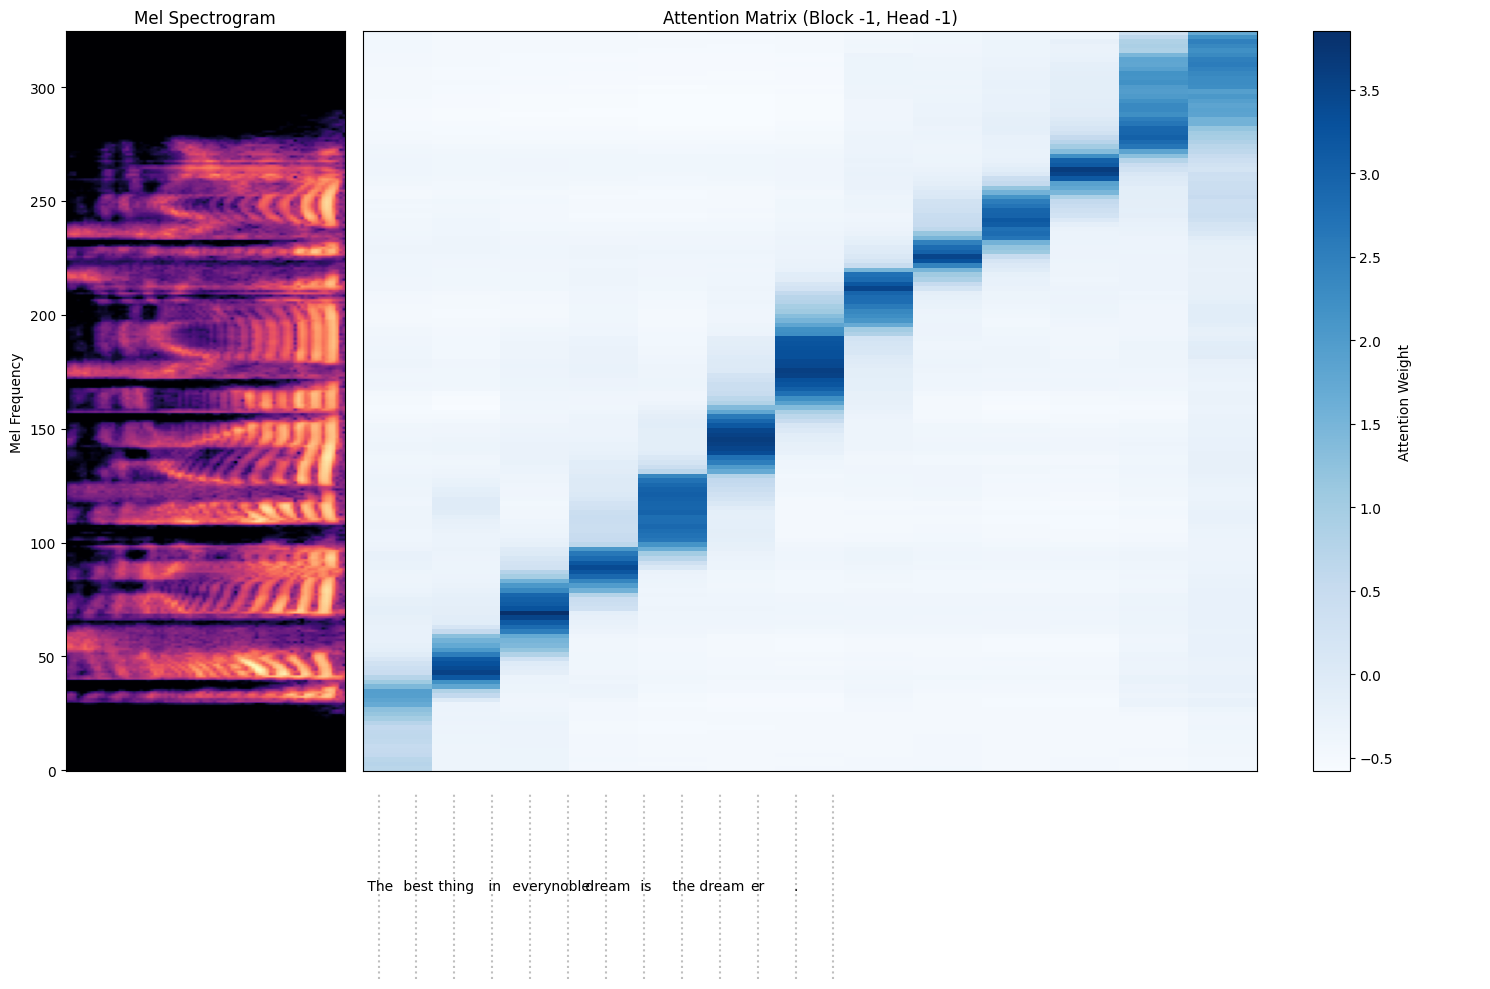

In [7]:
pred_tokens = result['segments'][0]['tokens']
decoded_tokens = [tokenizer.decode([token]) for token in pred_tokens[1:]]

# Create the visualization
matrix = attention_dict['final_matrix'].detach().cpu().numpy()

# flip it 
mel_plot = np.flipud(mel_or.cpu())
mel_plot = mel_plot.T

fig = plot_attention_with_spectrogram(matrix, mel_plot, decoded_tokens)
plt.show()

text is unaligned in the plot, I don't know how to align it correctly

BLOCK 0 Head 0


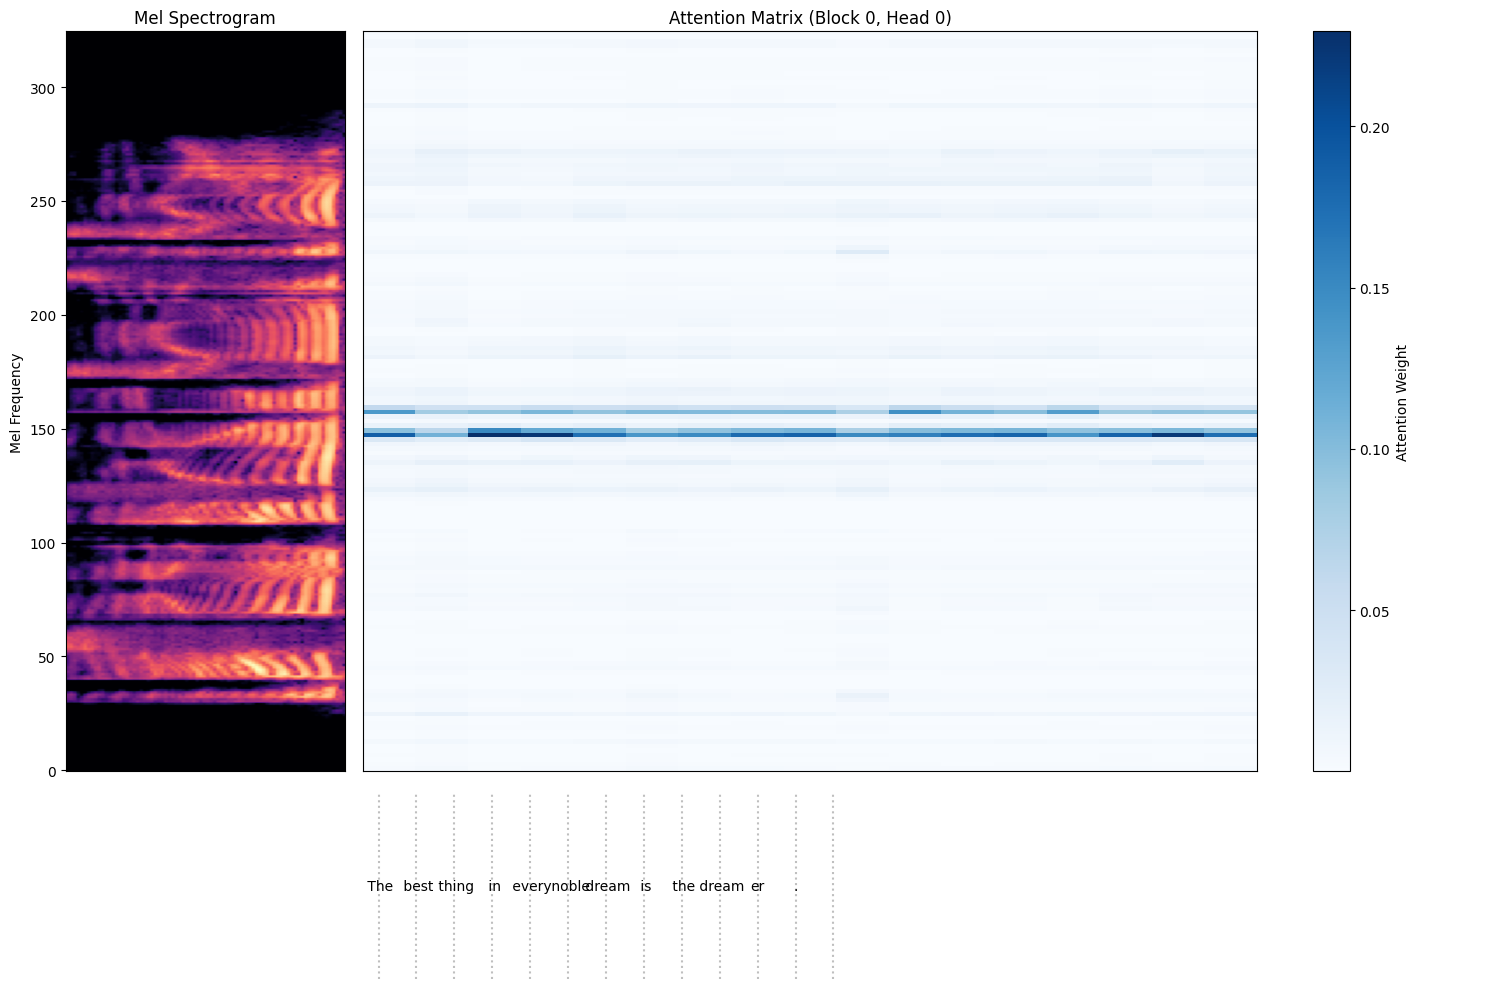

In [8]:
# plot some of the attention head
print("BLOCK 0", "Head 0")
i = 0
matrix = attention_dict['all_raw_weights'][i].detach().cpu().numpy()
fig = plot_attention_with_spectrogram(matrix, mel_plot, decoded_tokens, block=i//20, head=i%20)
plt.show()

## Candidate predictions

In [4]:
audio = whisper.load_audio(input_audio)
audio = whisper.pad_or_trim(audio)

# make log-Mel spectrogram and move to the same device as the model
mel = whisper.log_mel_spectrogram(audio, n_mels=model.dims.n_mels).to(model.device)

# detect the spoken language
_, probs = model.detect_language(mel)
print(f"Detected language: {max(probs, key=probs.get)}")

# decode the audio
options = whisper.DecodingOptions(beam_size=5, return_n_best=True,
                                 patience=1.1) # increasing patience for diverse results
result = whisper.decode(model, mel, options)

# print the recognized text
print(len(result))

Detected language: en
5


In [6]:
for i, res in enumerate(result):
    print(f"---Path {i + 1}---")
    print(f'text: {res.text}')
    print(f'log prob: {res.avg_logprob}')

---Path 1---
text: The best thing in every noble dream is the dreamer. The
log prob: -0.6639220118522644
---Path 2---
text: The best thing in every noble dream is the dreamer. Thank
log prob: -0.7211371064186096
---Path 3---
text: The best thing in every noble dream is the dreamer. The
log prob: -0.7224194407463074
---Path 4---
text: The best thing in every noble dream is the dreamer. www
log prob: -0.7255029082298279
---Path 5---
text: The best thing in every noble dream is the dreamer. Music
log prob: -0.7342345118522644
